In [3]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('algorithms').getOrCreate()

In [5]:
data = spark.read.load('Korea Income and Welfare Output.csv', format="csv", header=True, inferSchema=True)

data.printSchema()

print('Number of columns: ', len(data.columns))
print('Total number of rows: ', data.count())

root
 |-- year: integer (nullable = true)
 |-- region: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- year_born: integer (nullable = true)
 |-- education_tier: integer (nullable = true)
 |-- marriage_tier: integer (nullable = true)
 |-- income_tier: integer (nullable = true)
 |-- occupation_code: integer (nullable = true)

Number of columns:  8
Total number of rows:  52579


In [6]:
data.columns

['year',
 'region',
 'gender',
 'year_born',
 'education_tier',
 'marriage_tier',
 'income_tier',
 'occupation_code']

In [7]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [10]:
assembler = VectorAssembler(
  inputCols=['year',
             'region',
             'year_born',
             'education_tier',
             'marriage_tier',
             'income_tier',
             'occupation_code'],
              outputCol="features")

output = assembler.transform(data)
final_data = output.select("features",'gender')
final_data.show(10, False)

+------------------------------------+------+
|features                            |gender|
+------------------------------------+------+
|[2005.0,1.0,1962.0,2.0,1.0,2.0,51.0]|1     |
|[2006.0,1.0,1962.0,2.0,1.0,2.0,51.0]|1     |
|[2007.0,1.0,1962.0,2.0,1.0,2.0,51.0]|1     |
|[2008.0,1.0,1962.0,2.0,1.0,2.0,53.0]|1     |
|[2009.0,1.0,1962.0,2.0,1.0,2.0,53.0]|1     |
|[2010.0,1.0,1962.0,2.0,1.0,2.0,53.0]|1     |
|[2011.0,1.0,1962.0,2.0,1.0,2.0,53.0]|1     |
|[2012.0,1.0,1962.0,2.0,1.0,2.0,53.0]|1     |
|[2013.0,1.0,1962.0,2.0,1.0,2.0,53.0]|1     |
|[2014.0,1.0,1962.0,2.0,1.0,2.0,53.0]|1     |
+------------------------------------+------+
only showing top 10 rows



In [41]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import (DecisionTreeClassifier, RandomForestClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
acc_evaluator = MulticlassClassificationEvaluator(labelCol="gender", predictionCol="prediction", metricName="accuracy")

In [19]:
dtc = DecisionTreeClassifier(labelCol='gender',featuresCol='features')
dtc_model = dtc.fit(final_data)
dtc_predictions = dtc_model.transform(final_data)
dtc_acc = acc_evaluator.evaluate(dtc_predictions)
print(dtc_acc)

0.9032503470967497


In [39]:
rfc = RandomForestClassifier(labelCol='gender',featuresCol='features')
rfc_model_default = rfc.fit(final_data)
rfc_predictions_default = rfc_model_default.transform(final_data)
rfc_acc_default = acc_evaluator.evaluate(rfc_predictions_default)
print(rfc_acc_default)

0.8875026151124974


In [37]:
(train_data,test_data) = final_data.randomSplit([0.8,0.2])

print(train_data.count())
print(test_data.count())

42083
10496


In [38]:
rfc = RandomForestClassifier(labelCol='gender',featuresCol='features',numTrees=20)
rfc_model = rfc.fit(train_data)
rfc_predictions = rfc_model.transform(test_data)
rfc_predictions.show(10)

rfc_acc = acc_evaluator.evaluate(rfc_predictions)
print("The accuracy is {0:2.2f}%.".format(rfc_acc*100))

+--------------------+------+--------------------+--------------------+----------+
|            features|gender|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|[2005.0,1.0,1959....|     2|[0.0,2.0069222610...|[0.0,0.1003461130...|       2.0|
|[2005.0,1.0,1959....|     2|[0.0,3.7105316867...|[0.0,0.1855265843...|       2.0|
|[2005.0,1.0,1959....|     2|[0.0,3.7105316867...|[0.0,0.1855265843...|       2.0|
|[2005.0,1.0,1959....|     1|[0.0,15.102376315...|[0.0,0.7551188157...|       1.0|
|[2005.0,1.0,1959....|     2|[0.0,2.0069222610...|[0.0,0.1003461130...|       2.0|
|[2005.0,1.0,1959....|     2|[0.0,3.7105316867...|[0.0,0.1855265843...|       2.0|
|[2005.0,1.0,1959....|     2|[0.0,2.0069222610...|[0.0,0.1003461130...|       2.0|
|[2005.0,1.0,1959....|     2|[0.0,4.1149505927...|[0.0,0.2057475296...|       2.0|
|[2005.0,1.0,1959....|     2|[0.0,2.8181178896...|[0.0,0.1409058944...|       2.0|
|[20

In [49]:
importance = rfc_model.featureImportances
column_list = data.columns
column_list.remove("gender")
importanceList = [float(col) for col in importance]
final_importance = dict(zip(column_list, importanceList))
print(final_importance) 

{'year': 0.003129033607505035, 'region': 0.0023952753195017338, 'year_born': 0.02865657774250069, 'education_tier': 0.004019336624090191, 'marriage_tier': 0.7871454497252872, 'income_tier': 0.08771726772838784, 'occupation_code': 0.08693705925272718}


<AxesSubplot:xlabel='income_tier', ylabel='Count'>

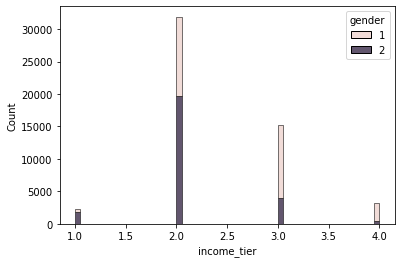

In [56]:
import seaborn as sns
pandasdata = data.toPandas()
sns.histplot(data = pandasdata, x = "income_tier", hue = 'gender', multiple="stack")

<AxesSubplot:xlabel='marriage_tier', ylabel='Count'>

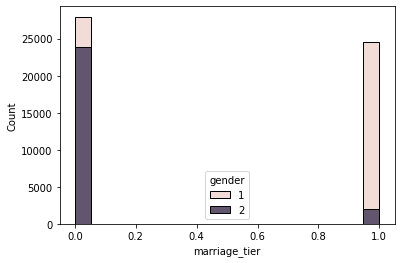

In [57]:
sns.histplot(data = pandasdata, x = "marriage_tier", hue = 'gender', multiple="stack")

In [73]:
rfc = RandomForestClassifier(labelCol='gender',featuresCol='features',numTrees=50)
rfc_model = rfc.fit(train_data)
rfc_predictions = rfc_model.transform(test_data)
rfc_predictions.show(10)

rfc_acc = acc_evaluator.evaluate(rfc_predictions)
print("The accuracy is {0:2.2f}%.".format(rfc_acc*100))

+--------------------+------+--------------------+--------------------+----------+
|            features|gender|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|[2005.0,1.0,1959....|     2|[0.0,4.9269891162...|[0.0,0.0985397823...|       2.0|
|[2005.0,1.0,1959....|     2|[0.0,9.8404904963...|[0.0,0.1968098099...|       2.0|
|[2005.0,1.0,1959....|     2|[0.0,9.8404904963...|[0.0,0.1968098099...|       2.0|
|[2005.0,1.0,1959....|     1|[0.0,38.845237536...|[0.0,0.7769047507...|       1.0|
|[2005.0,1.0,1959....|     2|[0.0,4.9269891162...|[0.0,0.0985397823...|       2.0|
|[2005.0,1.0,1959....|     2|[0.0,10.298757486...|[0.0,0.2059751497...|       2.0|
|[2005.0,1.0,1959....|     2|[0.0,4.9269891162...|[0.0,0.0985397823...|       2.0|
|[2005.0,1.0,1959....|     2|[0.0,11.442280816...|[0.0,0.2288456163...|       2.0|
|[2005.0,1.0,1959....|     2|[0.0,7.9998301943...|[0.0,0.1599966038...|       2.0|
|[20